# 1. Introduction

This notebook outlines the creation, compilation, and training of a deep learing network for audio classification using the [TorchSuite](https://github.com/sergio-sanz-rodriguez/torchsuite) framework.
 
https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

# 2. Importing Libraries

In [1]:
#!pip install torchaudio
#!pip install librosa
#!pip install soundfile
import os
import numpy as np
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from torchaudio.datasets import SPEECHCOMMANDS

from torchinfo import summary
from pathlib import Path
#from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import custom libraries
from utils.helper_functions import set_seeds
from engines.classification import ClassificationEngine
from engines.schedulers import FixedLRSchedulerWrapper
from transformers import Wav2Vec2Model

import warnings
os.environ['TORCH_USE_CUDA_DSA'] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="torch.autograd.graph")
warnings.filterwarnings("ignore", category=FutureWarning, module="onnxscript.converter")

# 3. Importing Dataset

In [2]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [3]:
# Get the list of labels available in the dataset
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [4]:
num_classes = len(labels)
print(f"Number of classes: {num_classes}")

Number of classes: 35


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


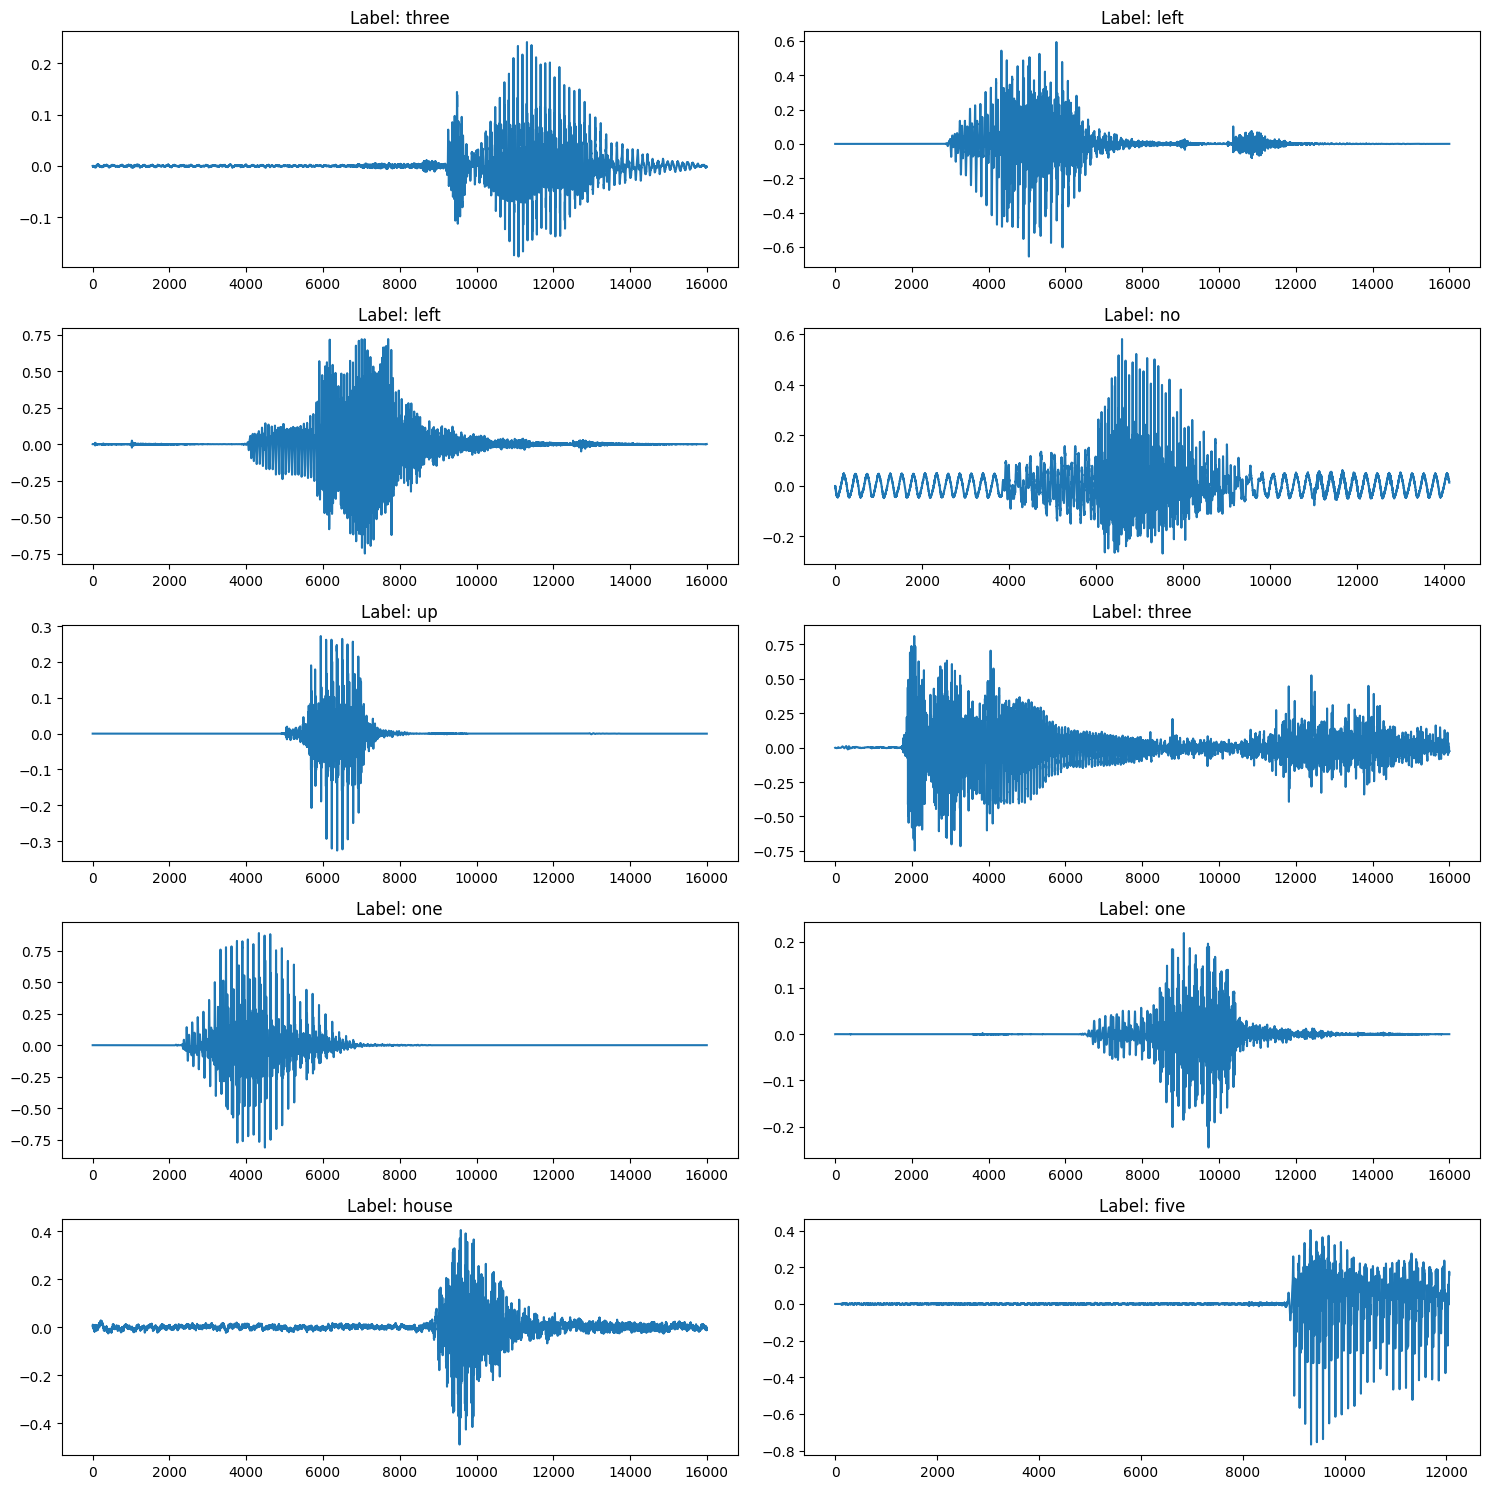

In [5]:
# Plot the audio waveform
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# Get the length of the train_set
train_set_size = len(train_set)

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
for col in range(2):
    for row in range(5):
        # Randomly select an index from the train_set
        idx = torch.randint(0, train_set_size, (1,)).item()
        
        # Get the waveform, sample rate, and label for the selected index
        w, _, l, *_ = train_set[idx]
        
        # Plot the waveform
        axs[row][col].plot(w.t().numpy())  # Ensure the waveform is transposed if necessary
        axs[row][col].set_title(f"Label: {l}")  # Set the label as the title

fig.tight_layout()
plt.show()

# 4. Audio Reproduction

In [6]:
# Play out some audio files
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [7]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

# 5. Specifying the Target Device

In [8]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Fri Feb 14 14:22:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             10W /  200W |    1511MiB /  12282MiB |     15%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [9]:
# Define some constants
NUM_WORKERS = os.cpu_count()
SEED = 42

# Create target model directory
MODEL_DIR = Path("outputs")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
set_seeds(SEED)

# 6. Preparing Dataloaders

In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [11]:
# Label-to-index, index-to-label conversors
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [12]:
# Define a collate function tat allows to iterate over a dataset by batches , we also apply the resampling, and the text encoding.

# Make all tensor in a batch the same length by padding with zeros
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        #print(f"Processing label: {label}")
        waveform_t = transform(waveform.squeeze(1))
        #tensors += [waveform_t]
        #targets += [label_to_index(label)]
        tensors.append(waveform_t)
        targets.append(label_to_index(label))

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    #targets = torch.stack(targets)
    targets = torch.tensor(targets, dtype=torch.long)

    #print("Collate function completed")

    # If shape is still [batch_size, 1, time_steps], squeeze the 1-dimension
    #tensors = tensors.squeeze(1)

    return tensors, targets


BATCH_SIZE = 256

if device == "cuda":
    num_workers = 0
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=pin_memory,
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [14]:
for batch in train_dataloader:
    x, y = batch
    print("x shape:", x.shape)  # Should be [batch_size, num_channels, seq_length]
    print("y shape:", y.shape)  # Should be [batch_size] (not [batch_size, 1])
    break

x shape: torch.Size([256, 1, 8000])
y shape: torch.Size([256])


# 7. Creating a Model

In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        #x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        #x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        #x = F.relu(x)
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        #x = x.permute(0, 2, 1)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


model = M5(n_input=transformed.shape[0], n_output=num_classes)

class Wav2Vec2Classifier(nn.Module):
    def __init__(self, base_model_name="facebook/wav2vec2-base", num_classes=35):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(base_model_name)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)

    def forward(self, x):
        x = self.wav2vec2(x).last_hidden_state  # Shape: (batch, seq_len, hidden_size)
        x = x.mean(dim=1)                       # Pooling to get (batch, hidden_size)
        x = self.classifier(x)                  # Shape: (batch, num_classes)
        return x

#model = Wav2Vec2Classifier(num_classes=num_classes)

# Unfreeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = True

# Compile model
model = torch.compile(model, backend="aot_eager")

# Send model to device
model.to(device)

# Print the summary of the model
#summary(model,
#        input_size=(BATCH_SIZE, 16000),
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

OptimizedModule(
  (_orig_mod): M5(
    (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (fc1): 

# 8. Training the Model

Epoch: 1/1 | Train: | loss: 3.4737 | acc: 0.0837 | fpr: 0.9981 | pauc: 0.5882 | time:   1m40s | lr: 0.0001000000
Epoch: 1/1 | Test:  | loss: 3.2761 | acc: 0.1498 | fpr: 0.9561 | pauc: 0.7055 | time:   0m15s | lr: 0.0001000000


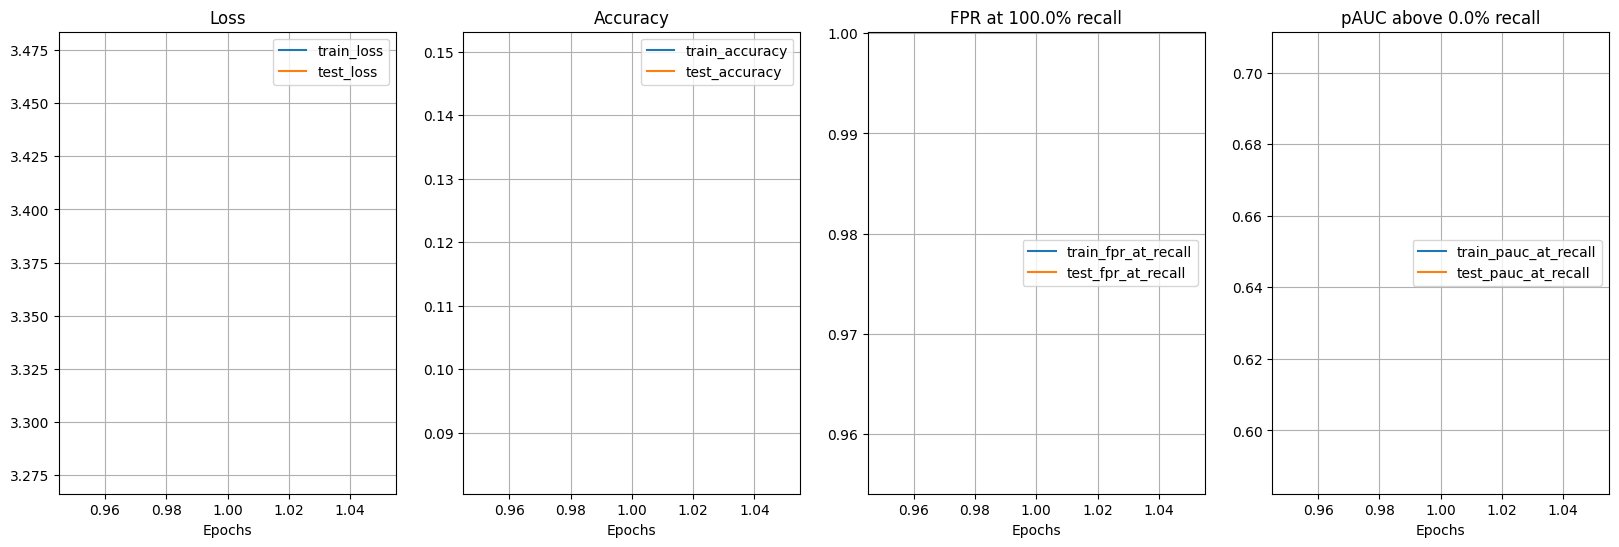

[INFO] Saving model to: outputs\model_epoch1.pth
[INFO] Saving model to: outputs\model_loss_epoch1.pth
[INFO] Saving model to: outputs\model_acc_epoch1.pth
[INFO] Training finished! Elapsed time:   1m59s


In [16]:
# Train the model
EPOCHS = 1
LR = 1e-4 #0.01
model_type="model"
model_name = model_type + ".pth"

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    weight_decay=0.0001
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# Set scheduler: from epoch #1 to #10 use CosinAnnealingRL, from epoch #11 to #20 a fixed learning rate
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=15)

# Set seeds
set_seeds(SEED)

# And train...

# Instantiate the classification engine with the created model and the target device
engine = ClassificationEngine(
    model=model,
    device=device)

# Configure the training method
results = engine.train(
    target_dir=MODEL_DIR,                       # Directory where the model will be saved
    model_name=model_name,                      # Name of the model
    save_best_model=["last", "loss", "acc"],    # Save the best models based on different criteria
    keep_best_models_in_memory=False,           # Do not keep the models stored in memory for the sake of training time and memory efficiency
    train_dataloader=train_dataloader,          # Train dataloader
    test_dataloader=test_dataloader,            # Test dataloader
    optimizer=optimizer,                        # Optimizer
    loss_fn=loss_fn,                            # Loss function
    recall_threshold=1.0,                       # False positive rate at recall_threshold recall
    recall_threshold_pauc=0.0,                  # Partial AUC score above recall_threshold_pauc recall
    scheduler=scheduler,                        # Scheduler
    epochs=EPOCHS,                              # Total number of epochs
    amp=True,                                   # Enable Automatic Mixed Precision (AMP)
    enable_clipping=False,                      # Disable clipping on gradients, only useful if training becomes unestable
    debug_mode=False,                           # Disable debug mode    
    accumulation_steps=1,                       # Accumulation steps 2: effective batch size = batch_size x accumulation steps
    apply_validation=True                       # Enable validation step
    )

In [17]:
indexes = engine.predict(
    model_state='acc',
    dataloader=test_dataloader,
    output_type='argmax').tolist()

[INFO] Model not found, using last-epoch model for prediction.


[WARNING] torch.inference_mode() check caused an issue. Falling back to torch.no_grad().


Making predictions:   0%|          | 0/43 [00:00<?, ?it/s]

In [18]:
labels = [index_to_label(i) for i in indexes]

In [19]:
labels

['seven',
 'zero',
 'up',
 'six',
 'off',
 'six',
 'six',
 'eight',
 'six',
 'six',
 'six',
 'six',
 'seven',
 'one',
 'on',
 'seven',
 'seven',
 'off',
 'yes',
 'five',
 'six',
 'go',
 'four',
 'stop',
 'stop',
 'stop',
 'yes',
 'stop',
 'zero',
 'one',
 'zero',
 'go',
 'stop',
 'no',
 'four',
 'up',
 'off',
 'left',
 'right',
 'zero',
 'up',
 'go',
 'yes',
 'yes',
 'up',
 'down',
 'no',
 'six',
 'yes',
 'six',
 'two',
 'stop',
 'stop',
 'six',
 'off',
 'six',
 'six',
 'zero',
 'seven',
 'go',
 'four',
 'on',
 'up',
 'zero',
 'up',
 'four',
 'two',
 'six',
 'nine',
 'no',
 'stop',
 'up',
 'nine',
 'yes',
 'seven',
 'nine',
 'right',
 'three',
 'yes',
 'four',
 'stop',
 'stop',
 'one',
 'eight',
 'off',
 'two',
 'three',
 'six',
 'nine',
 'up',
 'off',
 'go',
 'three',
 'on',
 'zero',
 'no',
 'three',
 'eight',
 'no',
 'off',
 'stop',
 'stop',
 'on',
 'three',
 'right',
 'two',
 'two',
 'yes',
 'nine',
 'two',
 'two',
 'stop',
 'two',
 'no',
 'six',
 'on',
 'two',
 'two',
 'stop',
 'le